## Learning bi-partite motifs based on a thermodynamic approach
### Implements the dynamic programming and the gradient descent

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import itertools
import pandas as pd
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import check_grad
from scipy.special import logsumexp
from Bio import SeqIO
import random
import multiprocessing
import multiprocessing as mp
import ctypes
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import clear_output

%load_ext cython

In [2]:
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()
directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

### cython

In [5]:
%%cython -f -I . --compile-args=-DCYTHON_TRACE=1  --compile-args=-DAVX2=1  --compile-args=-mavx2 


cimport cython
cimport numpy as np
ctypedef double c_float_t
import numpy as np
import itertools
from libc.math cimport exp,pow

float_dtype = np.NPY_DOUBLE
np.import_array()

cdef double cpi = np.pi
cdef int l = 3 #l_A=l_B=3 nucleotides

cpdef generate_kmer_inx():
    cdef dict vals = {'A':0,'C':1,'G':2,'T':3}
    cdef dict kmer_inx = {}
    
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

kmer_inx = generate_kmer_inx()
inx_kmer = {y:x for x,y in kmer_inx.items()}

cpdef seq2int_cy(str sequence):
    cdef int L = len(sequence)
    kmer_array = np.zeros(L, dtype=int)
    
    cdef i
    for i in range(l-1,L):
        kmer = sequence[i-l+1:i+1]
        kmer_array[i] = kmer_inx[kmer]
    return kmer_array        


    

cdef extern from "src_helper_avx.c":
    pass
    
cdef extern from "src_helper_avx.h":
    ctypedef struct DerParams:
        c_float_t* za_Ea_derivatives
        c_float_t* zb_Ea_derivatives
        c_float_t* za_Eb_derivatives
        c_float_t* zb_Eb_derivatives
        c_float_t* der_a
        c_float_t* der_b
        
    void initialize_DerParams(DerParams* params, int L, int no_kmers)
    void deinitialize_DerParams(DerParams* params)

    double sum_array_c(double* arr, int length)
    void sum_mat_rows(double* out, double* mat, int n_row, int n_col)
    
    void assign_za_c(int i, double* za, double* zb, double concentration_times_energy, int l)
    void assign_zb_c(long* x, int i, double* za, double* zb, double* Eb, double cab, double sf, double D, double sig, int l)
    
    void assign_za_E_derivatives_c(long* x, int i, double* za, double* zb, int L, int l, int no_kmers,
                                     DerParams* params, double* Ea, double* Eb, double cab)

    void assign_zb_E_derivatives_c(long* x, int i, double* za, double* zb, int L, int l, int no_kmers,
                                     DerParams* params, double* Ea, double* Eb, double cab, double sf, double D, double sig)

    void assign_za_D_derivative_c(int i, double* za_D_derivatives, double* zb_D_derivatives, double concentration_times_energy, int l)

    void assign_za_sig_derivative_c(int i, double* za_sig_derivatives, double* zb_sig_derivatives, double concentration_times_energy, int l)

    void assign_za_sf_derivative_c(int i, double* za_sf_derivatives, double* zb_sf_derivatives, double concentration_times_energy, int l)
    
    void assign_zb_D_derivative_c(int i, double* za, double* za_D_derivatives, double* zb_D_derivatives, double energy_b, 
                                         double cab, double sf, double D , double sig, int l)
    void assign_zb_sig_derivative_c(int i, double* za, double* za_sig_derivatives, double* zb_sig_derivatives, double energy_b, 
                                         double cab, double sf, double D , double sig, int l)
    void assign_zb_sf_derivative_c(int i, double* za, double* za_sf_derivatives, double* zb_sf_derivatives, double energy_b, 
                                         double cab, double sf, double D , double sig, int l)

    double cb_c(int, double, double, double)
    double cb_D_derivative_c(int, double, double, double)
    double cb_sig_derivative_c(int, double, double, double)
    double cb_sf_derivative_c(int, double, double, double)
    

cdef array_from_pointer(void* ptr, int size):
        cdef np.npy_intp shape_c[1]
        shape_c[0] = <np.npy_intp> size
        ndarray = np.PyArray_SimpleNewFromData(1, shape_c, float_dtype, ptr)
        return ndarray
    
    
@cython.boundscheck(False)  # Deactivate bounds checking   
def DP_Z_cy(double[:] args, long[:] x):
    
    cdef int L = len(x)
    cdef int no_kmers = len(kmer_inx)
    cdef double cab = 1.0

    cdef double[:] Ea = args[0:len(kmer_inx)]
    cdef double[:] Eb = args[len(kmer_inx):2*len(kmer_inx)]
    cdef double sf = args[-3]
    cdef double D = args[-2]
    cdef double sig = args[-1]
    
    #initialization of statistical weigths
    cdef double[:] za = np.zeros(L)
    cdef double[:] zb = np.zeros(L)

    cdef int i
    for i in range(0,l):
        zb[i] = 1 
        
        

    #initialization of derivatives
    cdef DerParams params = DerParams()
    initialize_DerParams(&params, L, no_kmers)


    cdef double[:] za_sf_derivatives = np.zeros(L)
    cdef double[:] zb_sf_derivatives = np.zeros(L)
    
    cdef double[:] za_D_derivatives = np.zeros(L)
    cdef double[:] zb_D_derivatives = np.zeros(L)

    cdef double[:] za_sig_derivatives = np.zeros(L)
    cdef double[:] zb_sig_derivatives = np.zeros(L)


    cdef int inx
    
    #precompute (binding energy of domain a binding at position i)*concentration
    cdef double energy_conc_a 
    
    #precompute binding energy of domain b binding at position i
    cdef double energy_b
    
    #dynamic programming calculation of z and derivatives 
    
    for i in range(l,L):
        energy_conc_a = cab*exp(-Ea[x[i]])
        energy_b = exp(-Eb[x[i]])
        
        #calculate statistical weights
        assign_za_c(i, &za[0], &zb[0], energy_conc_a, l)
        assign_zb_c(&x[0], i, &za[0], &zb[0], &Eb[0], cab, sf, D, sig, l)
        
        #calculate derivatives for all kmers (inx) at each position
        assign_za_E_derivatives_c(&x[0], i, &za[0], &zb[0], L, l, len(kmer_inx), 
                                      &params, &Ea[0], &Eb[0], cab)
        assign_zb_E_derivatives_c(&x[0], i, &za[0], &zb[0], L, l, len(kmer_inx), 
                                      &params, &Ea[0], &Eb[0], cab, sf, D, sig)
        
        
        assign_za_sf_derivative_c(i, &za_sf_derivatives[0], &zb_sf_derivatives[0], energy_conc_a, l)
        assign_zb_sf_derivative_c(i, &za[0], &za_sf_derivatives[0], &zb_sf_derivatives[0], energy_b, cab, sf, D, sig, l)
        
        assign_za_D_derivative_c(i, &za_D_derivatives[0], &zb_D_derivatives[0], energy_conc_a, l)
        assign_zb_D_derivative_c(i, &za[0], &za_D_derivatives[0], &zb_D_derivatives[0], energy_b, cab, sf, D, sig, l)
        
        assign_za_sig_derivative_c(i, &za_sig_derivatives[0], &zb_sig_derivatives[0], energy_conc_a, l)
        assign_zb_sig_derivative_c(i, &za[0], &za_sig_derivatives[0], &zb_sig_derivatives[0], energy_b, cab, sf, D, sig, l)

    Z_x = zb[L-1] + sum_array_c(&za[0], L)
    
    #derivative of Z(x)
    
    za_Ea_derivatives = array_from_pointer(params.za_Ea_derivatives, no_kmers * L).reshape(L,-1)
    za_Eb_derivatives = array_from_pointer(params.za_Eb_derivatives, no_kmers * L).reshape(L,-1)
    zb_Ea_derivatives = array_from_pointer(params.zb_Ea_derivatives, no_kmers * L).reshape(L,-1)
    zb_Eb_derivatives = array_from_pointer(params.zb_Eb_derivatives, no_kmers * L).reshape(L,-1)

    d_Ea = zb_Ea_derivatives[L-1,:] + np.sum(za_Ea_derivatives, axis=0)
    d_Eb = zb_Eb_derivatives[L-1,:] + np.sum(za_Eb_derivatives, axis=0)
  
    d_sf = zb_sf_derivatives[L-1] + sum_array_c(&za_sf_derivatives[0], L)
    d_D = zb_D_derivatives[L-1] + sum_array_c(&za_D_derivatives[0], L)
    d_sig = zb_sig_derivatives[L-1] + sum_array_c(&za_sig_derivatives[0], L)       
    gradient = np.concatenate([q.ravel() for q in [d_Ea, d_Eb, np.array([d_sf, d_D, d_sig])]])

    deinitialize_DerParams(&params)
    
    return Z_x, gradient

### implementation of the LL object

In [6]:
class nLL:
    def __init__(self, seqs_p, seqs_bg):
        
        self.N_p = len(seqs_p)
        self.N_bg = len(seqs_bg)

        #calculate background probabilities:

        #include positive sequences in bg sequences if not there
        X_bg_t = list(set(seqs_p + seqs_bg))  #number of unique sequences
        
        counts = np.zeros(len(X_bg_t))
        for i, x in enumerate(X_bg_t):
            counts[i] = seqs_bg.count(x)
            
        counts = counts + 1 #pseudocount to make sure 
        counts = counts/np.sum(counts)

        p_bg = dict(zip(X_bg_t, counts))

        self.pbg_xp = np.array([p_bg[x] for x in seqs_p])
        self.pbg_xbg = np.array([p_bg[xbg] for xbg in seqs_bg])
        
        #add a padding nucleotide to the beginning to make the calculations stable, binding starts at
        #position i=l so the padded nucleotide has no effect.
        self.X_p = [seq2int_cy('A' + x) for x in seqs_p] 
        self.X_bg = [seq2int_cy('A' + x) for x in seqs_bg]

        
    def assign_z_p(self, tup):
            i, args = tup
            d_z_x_np = np.frombuffer(dz.get_obj(), dtype=np.float64).reshape(-1, self.N_p)
            z[i], d_z_x_np[:,i] = DP_Z_cy(args, self.X_p[i])
            
    def assign_z_bg(self, tup):
            i, args = tup
            d_z_xbg_np = np.frombuffer(dz.get_obj(), dtype=np.float64).reshape(-1, self.N_bg)
            z[i], d_z_xbg_np[:,i] = DP_Z_cy(args, self.X_bg[i])

          

        
    def __call__(self, parameters):
        
        #number of positive variables (stacked at the end)
        n_pos = 3
        
        #exp parameters to make sure they are positive
        args = parameters.copy()
        args[-n_pos:] = np.exp(args[-n_pos:])
    
    
        #define weights and derivatives as a multiprocessing array
        z_x = mp.Array(ctypes.c_double, self.N_p)
        d_z_x = mp.Array(ctypes.c_double, (2*len(kmer_inx)+ n_pos)*self.N_p)

        z_xbg = mp.Array(ctypes.c_double, self.N_bg)
        d_z_xbg = mp.Array(ctypes.c_double, (2*len(kmer_inx)+ n_pos)*self.N_bg) 
        
        #parallelizing
        with multiprocessing.Pool(initializer=init, initargs=(z_x,d_z_x), processes=8) as pool:
            pool.map(self.assign_z_p, [(i, args) for i in range(len(self.X_p))])
        with multiprocessing.Pool(initializer=init, initargs=(z_xbg, d_z_xbg), processes=8)  as pool:
            pool.map(self.assign_z_bg, [(i, args) for i in range(len(self.X_bg))])
        
        #= convert to np array ======
        d_z_x = np.frombuffer(d_z_x.get_obj(), dtype=np.float64).reshape(-1, self.N_p)
        d_z_xbg = np.frombuffer(d_z_xbg.get_obj(), dtype=np.float64).reshape(-1, self.N_bg)
        z_x = np.frombuffer(z_x.get_obj(), dtype=np.float64)
        z_xbg = np.frombuffer(z_xbg.get_obj(), dtype=np.float64)
        #============================
        
        #calculate log likelihood of model given arg parameters
        ll = np.sum(np.log(self.pbg_xp) + np.log(np.ones(self.N_p) - (np.ones(self.N_p)/z_x)))
        ll -= self.N_p * logsumexp( np.log(self.pbg_xbg) + np.log(np.ones(self.N_bg) - (np.ones(self.N_bg)/z_xbg)) )
        
        #calculate partial derivatives of model given arg parameters
        dll = np.sum(d_z_x/(z_x*(z_x-1)), axis=1)
        dll -= self.N_p * ( np.sum((self.pbg_xbg * d_z_xbg)/(z_xbg*z_xbg), axis=1 ) / np.sum(self.pbg_xbg*(np.ones(self.N_bg) - (np.ones(self.N_bg)/z_xbg))))

        #exp modify dLL for positive elements
        dll[-n_pos:] = dll[-n_pos:]*args[-n_pos:]

        #regularize some parameters
        if False:
            comp = -3
            reg = 1e-8 
            ll -= np.power(args[comp],2)*reg
            dll[comp] -= 2*reg*args[comp]
        #print("final ll:\t%f"%ll)
        return -ll, -dll 

#make the arrays global to all processes
def init(z_array, dz_array):
    global z
    z = z_array    
    global dz
    dz = dz_array

In [7]:
def auc_evaluate(param, plus, bg):
    z_plus = np.zeros(len(plus))
    z_bg = np.zeros(len(bg))
    
    seq_pos = [seq2int_cy('A' + x) for x in plus]
    seq_bg = [seq2int_cy('A' + x) for x in bg]
    
    n_pos = 3
    #exp parameters to make sure they are positive
    args = param.copy()
    args[-n_pos:] = np.exp(args[-n_pos:])
        
    for i, x in enumerate(seq_pos):
        z_plus[i], _ = DP_Z_cy(args, x)
    
    for i, x in enumerate(seq_bg):
        z_bg[i], _ = DP_Z_cy(args, x)
        
    y_true = np.append(np.ones(len(plus)), np.zeros(len(bg)))
    y_score = np.append(z_plus, z_bg)
    
    auc = roc_auc_score(y_true, y_score)
    
    return auc

In [8]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [26]:
def plt_performance(auc_validation, auc_train, param_history, theta):
        
    x = np.arange(1, len(auc_validation)+1, 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('AUC')
    
    x_max = max(30, len(auc_validation))
    
    ax1.set_xlim(0,x_max)
    ax1.set_ylim(0.4,1)
    
    # get current motif ===========
    core1 = {}
    for i in range(len(kmer_inx)):
        core1[inx_kmer[i]] = theta[i]

    core1 = pd.Series(core1).sort_values(ascending=True)
    
    core2 = {}
    for i in range(len(kmer_inx)):
        core2[inx_kmer[i]] = theta[i+64]
    core2 = pd.Series(core2).sort_values(ascending=True)
    
    d = np.exp(theta[-2])
    sig = np.exp(theta[-1])
    #===============================================

    ax1.set_title('%s(%.2f) -- %.1f(%.1f) -- %s(%.2f)\n%s(%.2f) ----------------- %s(%.2f)\n%s(%.2f) ----------------- %s(%.2f)\ncurrent validation AUC: %.3f\nvariation index: %.2f'%(
        core1.index[0], core1.values[0],d,sig,core2.index[0], core2.values[0], 
        core1.index[1], core1.values[1], core2.index[1], core2.values[1], 
        core1.index[2], core1.values[2], core2.index[2], core2.values[2],
        auc_validation[-1],
        param_local_fluctuation(param_history)),
                loc='left')
    ax1.plot(x, auc_validation, color='blue', label='validation set ')  
    ax1.plot(x, auc_train, color='red', label='training set')
    ax1.legend()
    
    #Plot binding energies of one kmer per core ====
    
    #kmer1 = 'ATA'
    #kmer2 = 'TAT'
    
    core1_hist = [arr[kmer_inx[kmer1]] for arr in param_history]
    core2_hist = [arr[kmer_inx[kmer2]+ len(kmer_inx)] for arr in param_history]
    ax2.plot(x, core1_hist, color='blue', label='core1 %s E'%kmer1)
    ax2.plot(x, core2_hist, color='red', label='core2 %s E'%kmer2)
    ax2.legend()
    ax2.set_xlim(0,x_max)
        
    # plot sigma, D, and SF ========================
    sf_hist = [np.exp(arr[-3]) for arr in param_history]
    D_hist = [np.exp(arr[-2]) for arr in param_history]
    sig_hist = [np.exp(arr[-1]) for arr in param_history]
    
    ax3.set_xlabel('epoch')
    ax3.plot(x, D_hist, color='blue', label='D')  
    ax3.plot(x, sig_hist, color='red', label='sigma')
    
    ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
    ax4.set_ylabel('sf', color='green')  # we already handled the x-label with ax1
    ax4.plot(x, sf_hist, color='green', label='sf')
    ax4.tick_params(axis='y', labelcolor='green')    
    
    ax3.legend()    
    ax3.set_xlim(0,x_max)
    
    #================================================
    
    #plt.savefig('plots/'+ plot_name +'.pdf', bbox_inches='tight')
    
    clear_output(wait=True)
    plt.show()

In [31]:
def param_local_fluctuation(param_history):
    
    last_params = list(param_history[-1])
    min_energy_inx = last_params.index(min(last_params))
    energy_hist = [np.exp(arr[min_energy_inx]) for arr in param_history]
    
    D_hist = [np.exp(arr[-2]) for arr in param_history]
    sig_hist = [np.exp(arr[-1]) for arr in param_history]
    
    #define the strech which is assigned as local
    #if less than 5 epochs --> return 1
    if len(param_history)<5:
        return 1
    else:
        loc_len = 5
       
    #max(arr)-min(arr) for the last 5 elements of this parameter in adam optimization
    local_variation=np.array([max(a)-min(a) for a in [energy_hist[-loc_len:], D_hist[-loc_len:], sig_hist[-loc_len:]]])
    
    #max(arr)-min(arr) for all parameter history in adam optimization
    global_variation=np.array([max(a)-min(a) for a in [energy_hist, D_hist, sig_hist]])
        
    #return biggest ratio of local to glob variation
    return max(local_variation/global_variation)

In [10]:
def optimize_adam(plus, bg, plus_valid=None, bg_valid=None):

    #number of minibatches
    n_batch = 10
    
    #adam parameters
    alpha = 0.01
    beta_1 = 0.9
    beta_2 = 0.999   
    epsilon = 1e-8

    #initialize the vector
    theta_0 = parameters  
    n_param = len(parameters)

    m_t = np.zeros(n_param) 
    v_t = np.zeros(n_param)  

    t = 0
    f_t = 42 #initialize with random number
    epoch = 0

    evaluate = plus_valid is not None
    

    #auc array tracks auc values
    auc_validation = []
    auc_train = []
    param_history = []    
    
    #calculate the stretch of reduced performance
    reduction = 0
    
    while(True):
        
        #split data into several minibatches
        epoch += 1
        #print('epoch = %d'%epoch)
        pos_batches = partition(plus, n_batch)
        bg_batches  = partition(bg, n_batch)

        #enumerate minibatches
        for i in range(n_batch):

            nll_obj = nLL(pos_batches[i],bg_batches[i])

            t+=1

            f_prev = f_t

            #computes the gradient of the stochastic function
            f_t, g_t = nll_obj(theta_0) 

            #updates the moving averages of the gradient
            m_t = beta_1*m_t + (1-beta_1)*g_t 

            #updates the moving averages of the squared gradient
            v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) 

            #calculates the bias-corrected estimates
            m_cap = m_t/(1-(beta_1**t)) 

            #calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**t)) 

            #before updating parameters plot performance on validation set
            if evaluate and i==0:
                aucv = auc_evaluate(theta_0, plus_valid, bg_valid)
                auct = auc_evaluate(theta_0, plus, bg)
                auc_validation.append(aucv)
                auc_train.append(auct)
                param_history.append(theta_0)
                plt_performance(auc_validation, auc_train, param_history, theta_0)
                
                
            #updates the parameters by moving a step towards gradients
            theta_0_prev = theta_0 
            theta_0 = theta_0 - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon) 

            if(theta_0 == theta_0_prev).all(): #checks if it is converged or not
                print("parameters converged")
                return theta_0
            
        if evaluate and len(auc_validation)>1:
            if auc_validation[-1] <= auc_validation[-2]:
                reduction += 1
        
        #stop when validation set performs worse for a
        if reduction > 15:
            np.savetxt(fname='param/'+ plot_name +'.txt', X=np.insert(theta_0,0,f_t))
            return theta_0, g_t

### Import fasta files

In [11]:
def parse_fasta(file_name):
    input_seq_iterator = SeqIO.parse(file_name, "fasta")
    return [str(record.seq) for record in input_seq_iterator]

In [12]:
def swap_cores (args):
    core1_args = args[:len(kmer_inx)]
    core2_args = args[len(kmer_inx):len(kmer_inx)*2]
    return np.concatenate([x.ravel() for x in [core2_args, core1_args, np.array([args[-2], args[-1]])]])

In [28]:
if False:
    set_size = 15000
    bg = parse_fasta('HNRNPA0_1_TGTCGA40NCCGA_AAG_1.fasta.tmp')
    plus = parse_fasta('HNRNPA0_4_TGTCGA40NCCGA_AAG_4.fasta.tmp')

    bg = random.sample(bg, set_size)
    plus = random.sample(plus, set_size)
    
    bg   = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in bg]
    plus = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in plus]
    
else:
    background_set = parse_fasta('negatives_toy.fasta')
    positive_set = parse_fasta('positives_toy.fasta')
    
    bg_train, bg_test, bg_valid = partition(background_set, 3)
    pos_train, pos_test, pos_valid = partition(positive_set, 3)

### ADAM optimization

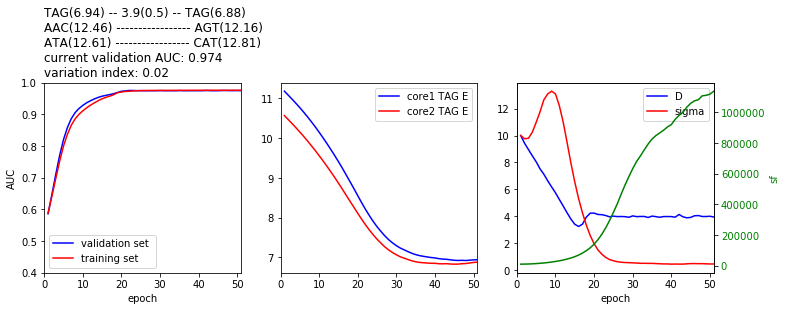

In [34]:
kmer1 = 'TAG'
kmer2 = 'TAG'

for i in range(1):
    Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
    Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
    sf = np.log(10000)
    D = np.log(10)
    sig = np.log(10)

    parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, D, sig])]])

    identifier = random.randint(1,999)
    plot_name = 'TAG_TAG_1000_%d_ADAM'%identifier

    %matplotlib inline
    n=1000
    x_opt, grad = optimize_adam(random.sample(pos_train, n), random.sample(bg_train, n), pos_valid[:n], bg_valid[:n])